In [12]:
import cv2
import matplotlib.pyplot as plt
from copy import copy
import pandas as pd
import os
from face_detection import detect_faces, compute_face_areas_with_percents, cascade

# В чем вообще идея:

### Если я пройдусь по всем файлам из директории frames_2012, я смогу создать датафрейм с колонками "название файла", "количество лиц", "процент, который занимают лица на картинке". В дальнейшем можно было бы построить гистограмму распределения, посмотреть, что превалирует (распределение количества лиц, распредение процентажа) + построить график того, в каких моментах фильма процентаж от одного лица наиболее высокий -> так я могла бы находить на протяжении фильма крупные планы (например). В целом это могло бы быть актуально в случае попытки находить крупные планы не только людей, но и вещей, в таком случае мы видели бы, как толстовская детальность передается в фильме.

### Кроме того, я могла бы анализировать цветовую передачу кадров - там, где сумма значений пикселей на напротяжении нескольких кадров равна нулю, скорее всего есть склейка монтажная. Тогда можно было бы проверить, насколько быстрое повествование, у кого кадры (сцены) длиннее, у кого наоборот короче.

##### Следующие чанки с функциями и классификатором - временные, они будут перенесены в отдельный файл .py, откуда я буду их импортировать (хотя там возникает проблема с функцией classificator, файлы из которой по сути потом использует функция detect_faces

In [13]:
def classificator(name):
    cascade = cv2.CascadeClassifier(name)
    return cascade

def detect_faces(cascade, image, scaleFactor = 1.1, return_faces=False): 
    '''
    :scaleFactor: то, во сколько раз мы уменьшаем наше окно поиска лиц или чего-либо еще при каждой итерации
    '''
    
    '''на всякий случай поработаем с копией'''
    image_copy = image.copy()

    '''копию картинки переводим в серый, потому что detectMultiScale
       берет на фход только серые изображения'''
    gray_image = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

    '''Детектим лица с помощью haar classifier''' 
    faces = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)
    
#     print("Лиц обнаружено: " + format(len(faces)))

    for (x, y, w, h) in faces:
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 255, 0), 3)

    return (image_copy, faces) if return_faces else image_copy

def compute_face_areas_with_percents(array_of_faces, image):
    '''This function computes rectangle area and the percentage of it.
    It does not work without function detect_faces, which provides the array of faces (coordinates)'''
    
    img_h, img_w = image.shape[:2] #we do not need rgb size
    img_area = img_h * img_w
    areas = []
    percentages_of_area = []
    for face in array_of_faces:
        w, h = face[2], face[3]
        area = w * h
        percent = area / img_area * 100
        percentages_of_area.append(percent)
        areas.append(area)
    return areas, percentages_of_area

In [14]:
frontal_face_cascade = classificator('../haarcascade_frontalface_default.xml')
profile_face_cascade = classificator('../haarcascade_profileface.xml')

## Создадим функцию, которая раскладывает наше видео на кадры

In [15]:
def frame_extraction(film_path):
    vidcap = cv2.VideoCapture(film_path)
    success,image = vidcap.read()
    count = 0
    while success:
        cv2.imwrite("frames_2012/frame_{}.jpg".format(count), image)
        success,image = vidcap.read()
#         print('Read a new frame: ', success, ' ', count) #это вероятно можно убрать
        count += 1

## Попробуем разложить трейлер "Анны Карениной" на кадры, которые сохранятся в папке frames_2012

In [16]:
film_path = 'Anna_Karenina_Official_Trailer.mp4'

In [21]:
'''на выдаче пока не поняла, почему последнее число 3615, если всего кадров должно быть 3624 (ведь длина трейлера - 2 мин 31 сек)
UPD: gjx'''
frame_extraction(film_path)

## Теперь к каждому кадру применим наши функции из скрипта Karenina_OpenCV_practice (которые пока что записаны выше). Результат запишем в датафрейм.

In [22]:
columns_name = ['frame_num', 'num_of_faces', 'percentage']
data = pd.DataFrame(columns = columns_name)

In [23]:
directory = 'frames_2012'
for file in os.listdir(directory):
    if file.endswith('.jpg'):
        image = cv2.imread(os.path.join(directory, file)) #читаем файл, получаем матрицу
        image, faces = detect_faces(frontal_face_cascade, image, 1.2, True) #находим лица на картинке, 
                                                                            #получаем координаты картинки и координаты лиц
        result = compute_face_areas_with_percents(faces, image) #подсчитываем площадь (пиксели в кв) и процент от картинки
        
        dict_of_frames = {'frame_num': file, 'num_of_faces': len(result[0]), 'percentage': result[1]}
#         print(dict_of_frames)
        data = data.append(dict_of_frames, ignore_index=True)

In [24]:
'''Возникшие проблемы: 
1) надо понять, как это нормально отсортировать, вероятно, упорядочивать надо еще на этапе обхода директории (странно, что он рандомно
   файлы располагает, а не по порядку, как они лежат у меня в папочке)
2) Надо улучшить df, потому что пока что наличие списка в значении процентажа не совсем правильно и не очень красиво
3) проблема с детектингом - все-таки эта программа совершает значительные ошибки в распознавании лиц
4) надо обрезать черные рамки сверху и снизу кадра
5) надо придумать, что делать с черными кадрами, потому что если их несколько, то скорее всего это склейка, и тогда эту информацию 
можно как-то использовать, но пока что эти кадры просто занимаю место в df'''

data.sort_values(by = 'num_of_faces')

,frame_num,num_of_faces,percentage
0,frame_3284.jpg,0,[]
2081,frame_334.jpg,0,[]
2082,frame_1773.jpg,0,[]
2084,frame_3602.jpg,0,[]
2085,frame_1015.jpg,0,[]
...,...,...,...
2232,frame_2119.jpg,20,"[0.22960069444444442, 0.2197265625, 0.30479600..."
2036,frame_2118.jpg,20,"[0.22960069444444442, 0.2197265625, 0.30479600..."
2488,frame_2122.jpg,20,"[0.2396918402777778, 0.22960069444444442, 0.29..."
1570,frame_2115.jpg,20,"[0.2396918402777778, 0.22960069444444442, 0.31..."


### Посмотрим на кадры, где только одно лица было зафиксировано:

In [74]:
one = data.loc[data['num_of_faces'] == 1]

In [75]:
pd.set_option('display.max_rows', None)

In [77]:
print(one.sort_values(by = 'percentage'))

           frame_num num_of_faces             percentage
3552  frame_1918.jpg            1  [0.07335069444444443]
506   frame_1913.jpg            1  [0.07335069444444443]
60    frame_1915.jpg            1         [0.0791015625]
288   frame_1916.jpg            1         [0.0791015625]
169   frame_1914.jpg            1         [0.0791015625]
393   frame_1917.jpg            1  [0.08506944444444443]
846   frame_1911.jpg            1  [0.08506944444444443]
1614  frame_1191.jpg            1  [0.08506944444444443]
2206  frame_1174.jpg            1           [0.09765625]
1987  frame_1177.jpg            1           [0.09765625]
1769  frame_1190.jpg            1   [0.1042751736111111]
928   frame_1369.jpg            1   [0.1042751736111111]
1099  frame_1368.jpg            1   [0.1042751736111111]
1322  frame_1182.jpg            1   [0.1042751736111111]
1831  frame_1189.jpg            1   [0.1042751736111111]
1840  frame_1176.jpg            1   [0.1042751736111111]
655   frame_2162.jpg           

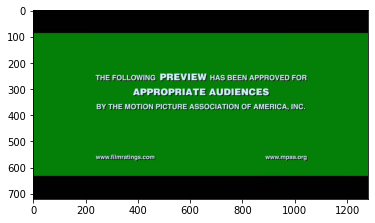

In [31]:
img = cv2.imread('/Users/tonleon/Documents/GitHub/Diploma/Films/frames_2012/frame_1.jpg')
img.shape
plt.imshow(img)

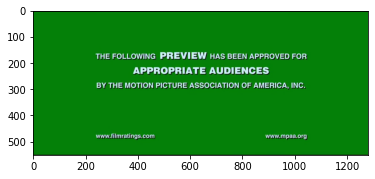

In [39]:
cropped = img[82:633, 0:]
plt.imshow(cropped)